In [242]:
import pandas as pd 

In [243]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import load_model 

In [244]:
data = pd.read_csv('Data/movie_data.csv')

print(data)

                                                  review  sentiment
0      In 1974, the teenager Martha Moxley (Maggie Gr...          1
1      OK... so... I really like Kris Kristofferson a...          0
2      ***SPOILER*** Do not read this, if you think a...          0
3      hi for all the people who have seen this wonde...          1
4      I recently bought the DVD, forgetting just how...          0
...                                                  ...        ...
49995  OK, lets start with the best. the building. al...          0
49996  The British 'heritage film' industry is out of...          0
49997  I don't even know where to begin on this one. ...          0
49998  Richard Tyler is a little boy who is scared of...          0
49999  I waited long to watch this movie. Also becaus...          1

[50000 rows x 2 columns]


In [245]:
def load_dataset():
    df = pd.read_csv('Data/movie_data.csv')
    X_data = df['review']       # Reviews/Input
    y_data = df['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    X_data = X_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    X_data = X_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    X_data = X_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    X_data = X_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # Conevrting y_data into int
    y_data = y_data.astype('int')
   

    return X_data, y_data

X_data, y_data = load_dataset()

#print('Reviews')
#print(x_data, '\n')
#print('Sentiment')
#print(y_data)

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.2)

In [247]:
#Calculating max length for padding the sequence
def get_max_length():
    review_length = []
    for review in X_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [248]:
# ENCODE REVIEW
token = Tokenizer(lower=False)    # no need lower, because already lowered the data in load_data()
token.fit_on_texts(X_train)
X_train = token.texts_to_sequences(X_train)
X_test = token.texts_to_sequences(X_test)

max_length = get_max_length()


In [249]:
X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

In [250]:
print('Encoded X Train\n', X_train, '\n')
print('Encoded X Test\n', X_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[ 1280   199   738 ...  2180     3   168]
 [   16 28150   809 ...     0     0     0]
 [   16   150     4 ...     0     0     0]
 ...
 [  119     3    23 ...     0     0     0]
 [    8    73     5 ...   513   380   128]
 [    1   119     3 ...   608  1813  7728]] 

Encoded X Test
 [[ 6284  1702  2619 ...   189  1326 10335]
 [    1    66 15770 ...     0     0     0]
 [  473    15  1331 ...     0     0     0]
 ...
 [ 7709  2047     3 ...    29     3   562]
 [   14    18   935 ...     0     0     0]
 [ 1420   694     8 ...     0     0     0]] 

Maximum review length:  130


In [132]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 130, 32)           2956384   
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,981,281
Trainable params: 2,981,281
Non-trainable params: 0
_________________________________________________________________
None


In [133]:
from tensorflow.keras.callbacks import ModelCheckpoint 

In [134]:
import os
file_name = 'LSTM1.h5'
checkpoint_path =os.path.join('models',file_name)

call_backs = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path,
                                               monitor ='val_accuracy',
                                               verbose =1,
                                               save_freq='epoch',
                                               save_best_only = False,
                                               save_weights_only= False,
                                               mode = 'max')

In [136]:
history = model.fit(X_train,y_train,epochs=10,validation_split = 0.2,batch_size=128,callbacks=call_backs)

In [237]:
loaded_model = load_model('models/LSTM1.h5')

In [238]:
pred = loaded_model.predict(X_test)


In [239]:
y_pred= []
for i in pred:
    if i>0.5:
        
        y_pred.append(1)
    else:
        y_pred.append(0)


In [240]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [241]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [77]:
metrics.accuracy_score(y_test,y_pred)

0.8602

In [78]:
review = "Nothing was typical about this. Everything was beautifully done in this movie, the story, the flow, the scenario, everything. I highly recommend it for mystery lovers, for anyone who wants to watch a good movie!"
# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)
#print('Cleaned: ', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]
tokenize_words = token.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
#print(tokenize_words)

#print('Filtered: ', filtered)

In [79]:
result = model.predict(tokenize_words)
#print(result)
if result >= 0.7:
    print('positive')
else:
    print('negative')

negative


In [80]:
history.history

{'loss': [0.16945891082286835,
  0.09571155905723572,
  0.05909571051597595,
  0.04647456482052803,
  0.03548596054315567,
  0.058155499398708344,
  0.038048308342695236,
  0.1489347517490387,
  0.13872027397155762,
  0.04269442707300186],
 'accuracy': [0.9438124895095825,
  0.9735312461853027,
  0.9854687452316284,
  0.989062488079071,
  0.9917812347412109,
  0.9865624904632568,
  0.9907500147819519,
  0.9635312557220459,
  0.9638124704360962,
  0.9896875023841858],
 'val_loss': [0.32820531725883484,
  0.4005042016506195,
  0.3822210729122162,
  0.46928998827934265,
  0.5421878099441528,
  0.4863218367099762,
  0.7223219871520996,
  0.5392511487007141,
  0.5307446718215942,
  0.5287458896636963],
 'val_accuracy': [0.871999979019165,
  0.8698750138282776,
  0.8663750290870667,
  0.8650000095367432,
  0.8601250052452087,
  0.8565000295639038,
  0.8539999723434448,
  0.7927500009536743,
  0.8522499799728394,
  0.8526250123977661]}

In [81]:
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[4513  585]
 [ 813 4089]]


In [89]:
def plot_learningcurve(history,epochs):
    epoch_range = range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    
    plt.plot(epoch_range,history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accurcay')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()
    plt.plot(epoch_range,history.history['loss'])
    
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()

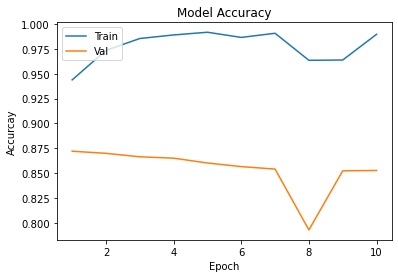

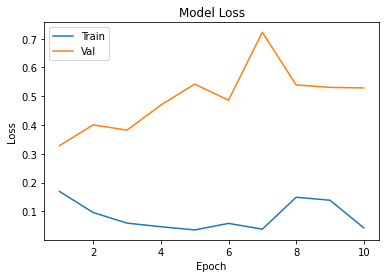

In [90]:
plot_learningcurve(history,10)

In [91]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 128

model2 = Sequential()
model2.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model2.add(LSTM(LSTM_OUT))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 32)           2956384   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,038,945
Trainable params: 3,038,945
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
import os
file_name = 'LSTM2.h5'
checkpoint_path =os.path.join('models',file_name)

call_backs = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path,
                                               monitor ='val_accuracy',
                                               verbose =1,
                                               save_freq='epoch',
                                               save_best_only = False,
                                               save_weights_only= False,
                                               mode = 'max')

In [96]:
history = model2.fit(X_train,y_train,epochs=5,validation_split = 0.2,batch_size=128,callbacks=call_backs)

Epoch 1/5
250/250 [==============================] - 100s 401ms/step - loss: 0.0916 - accuracy: 0.9744 - val_loss: 0.4444 - val_accuracy: 0.8660

Epoch 00001: saving model to models\LSTM2.h5
Epoch 2/5
250/250 [==============================] - 104s 415ms/step - loss: 0.0737 - accuracy: 0.9810 - val_loss: 0.4484 - val_accuracy: 0.8619

Epoch 00002: saving model to models\LSTM2.h5
Epoch 3/5
250/250 [==============================] - 100s 401ms/step - loss: 0.0669 - accuracy: 0.9830 - val_loss: 0.3911 - val_accuracy: 0.8586

Epoch 00003: saving model to models\LSTM2.h5
Epoch 4/5
250/250 [==============================] - 98s 392ms/step - loss: 0.0476 - accuracy: 0.9887 - val_loss: 0.5321 - val_accuracy: 0.8559

Epoch 00004: saving model to models\LSTM2.h5
Epoch 5/5
250/250 [==============================] - 96s 384ms/step - loss: 0.0407 - accuracy: 0.9912 - val_loss: 0.5895 - val_accuracy: 0.8537

Epoch 00005: saving model to models\LSTM2.h5


In [97]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [146]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 128

model3 = Sequential()
model3.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model3.add(LSTM(LSTM_OUT))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model3.summary())
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 130, 32)           2956384   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 3,038,945
Trainable params: 3,038,945
Non-trainable params: 0
_________________________________________________________________
None


In [147]:
import os
file_name = 'LSTM3.h5'
checkpoint_path =os.path.join('models',file_name)

call_backs = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path,
                                               monitor ='val_accuracy',
                                               verbose =1,
                                               save_freq='epoch',
                                               save_best_only = False,
                                               save_weights_only= False,
                                               mode = 'max')

In [148]:
history = model3.fit(X_train,y_train,epochs=5,validation_split = 0.2,batch_size=128,callbacks=call_backs)
#history = model.fit(X_train,y_train,epochs=10,validation_split = 0.2,batch_size=128,callbacks=call_backs)

Epoch 1/5
250/250 [==============================] - 97s 373ms/step - loss: 0.6930 - accuracy: 0.5115 - val_loss: 0.6926 - val_accuracy: 0.5370

Epoch 00001: saving model to models\LSTM3.h5
Epoch 2/5
250/250 [==============================] - 89s 356ms/step - loss: 0.4962 - accuracy: 0.7384 - val_loss: 0.3508 - val_accuracy: 0.8534

Epoch 00002: saving model to models\LSTM3.h5
Epoch 3/5
250/250 [==============================] - 89s 356ms/step - loss: 0.2687 - accuracy: 0.8966 - val_loss: 0.3519 - val_accuracy: 0.8640

Epoch 00003: saving model to models\LSTM3.h5
Epoch 4/5
250/250 [==============================] - 92s 368ms/step - loss: 0.1885 - accuracy: 0.9327 - val_loss: 0.3124 - val_accuracy: 0.8723

Epoch 00004: saving model to models\LSTM3.h5
Epoch 5/5
250/250 [==============================] - 99s 396ms/step - loss: 0.1355 - accuracy: 0.9558 - val_loss: 0.4361 - val_accuracy: 0.8604

Epoch 00005: saving model to models\LSTM3.h5


In [149]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



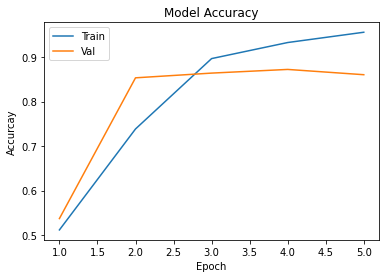

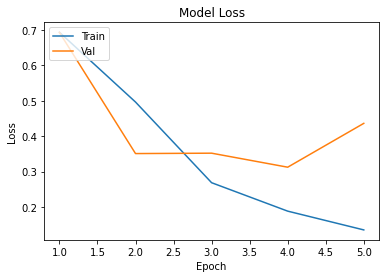

In [150]:
plot_learningcurve(history,5)

In [155]:
# ARCHITECTURE
EMBED_DIM = 32
LSTM_OUT = 128

model4 = Sequential()
model4.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model4.add(LSTM(LSTM_OUT))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

print(model4.summary())
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 130, 32)           2956384   
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 3,038,945
Trainable params: 3,038,945
Non-trainable params: 0
_________________________________________________________________
None


In [158]:
import os
file_name = 'LSTM4.h5'
checkpoint_path =os.path.join('models',file_name)

call_backs = tf.keras.callbacks.ModelCheckpoint(filepath =checkpoint_path,
                                               monitor ='val_accuracy',
                                               verbose =1,
                                               save_freq='epoch',
                                               save_best_only = False,
                                               save_weights_only= False,
                                               mode = 'max')

In [159]:
history = model4.fit(X_train,y_train,epochs=5,validation_split = 0.2,batch_size=128,callbacks=call_backs)

Epoch 1/5
250/250 [==============================] - 100s 399ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.4924

Epoch 00001: saving model to models\LSTM4.h5
Epoch 2/5
250/250 [==============================] - 110s 441ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6933 - val_accuracy: 0.4929

Epoch 00002: saving model to models\LSTM4.h5
Epoch 3/5
250/250 [==============================] - 101s 403ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6933 - val_accuracy: 0.4945

Epoch 00003: saving model to models\LSTM4.h5
Epoch 4/5
250/250 [==============================] - 99s 397ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.4951

Epoch 00004: saving model to models\LSTM4.h5
Epoch 5/5
250/250 [==============================] - 107s 430ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.4944

Epoch 00005: saving model to models\LSTM4.h5


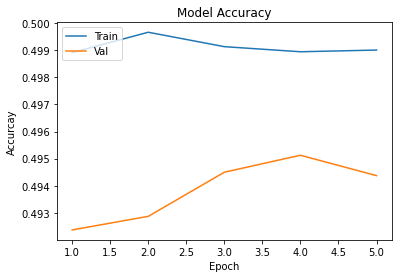

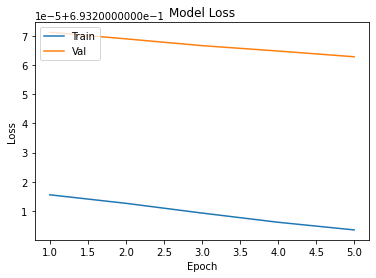

In [160]:
plot_learningcurve(history,5)

In [161]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
#https://itechindia.co/blog/which-of-the-3-algorithms-models-should-you-choose-for-sentiment-analysis-2/

In [164]:
#Ref:https://www.justintodata.com/sentiment-analysis-with-deep-learning-lstm-keras-python/
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

auc_lstm = roc_auc_score(y_test, y_pred)
auc_lstm

0.859699222053144

In [263]:

def predict(path):
    y_pred= []
    loaded_model = load_model(path)
    pred = loaded_model.predict(X_test)
    
    for i in pred:
        if i>0.5:

            y_pred.append(1)
        else:
            y_pred.append(0)
    return y_pred
        



In [252]:
predict('models/LSTM1.h5')

In [253]:
len(y_test),len(y_pred)

(10000, 10000)

In [254]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
#Go back and split the data again

In [257]:
predict('models/LSTM2.h5')

In [258]:
len(y_pred),len(y_test)

(10000, 10000)

In [259]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4902
           1       0.86      0.87      0.86      5098

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [261]:
predict('models/LSTM3.h5')
len(y_pred),len(y_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [264]:
predict('models/LSTM4.h5')
len(y_pred),len(y_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      4902
           1       0.85      0.89      0.87      5098

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
loaded_model = load_model(path)
    pred = loaded_model.predict(X_test)
    
    for i in pred:
        if i>0.5:

            y_pred.append(1)
        else:
            y_pred.append(0)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
predict('models/LSTM3.h5')

In [266]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

auc_lstm = roc_auc_score(y_test, y_pred)
auc_lstm

0.8639243651841293

In [274]:
y_test_pred = loaded_model.predict(X_test)
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0],)

In [275]:
#We can also visualize the classifications.

    
df_pred = pd.DataFrame(data={'y_actual': y_test, 'y_pred': y_test_pred})

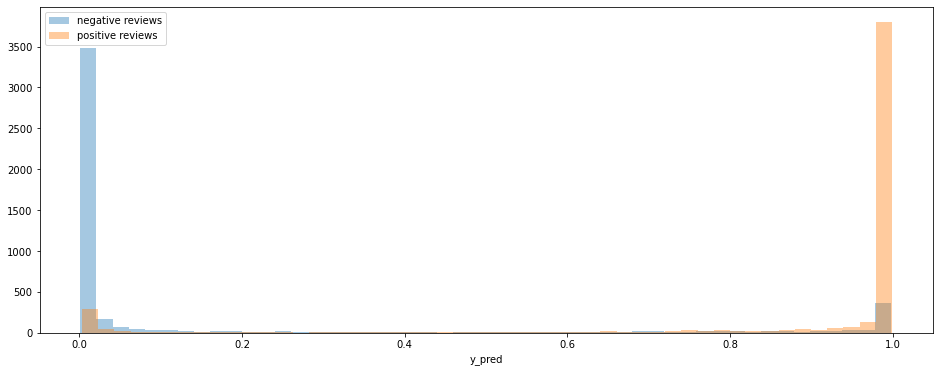

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

msk = df_pred['y_actual'] == 0
sns.distplot(df_pred.loc[msk, 'y_pred'], label='negative reviews', kde=False)
sns.distplot(df_pred.loc[~msk, 'y_pred'], label='positive reviews', kde=False)
plt.legend()

In [277]:
#We can see that the majority of positive reviews (orange) has y_pred value closer to 1;
#and most of the negative reviews (blue) has y_pred closer to 0.

In [ ]:
#https://towardsdatascience.com/machine-learning-classifier-evaluation-using-roc-and-cap-curves-7db60fe6b716

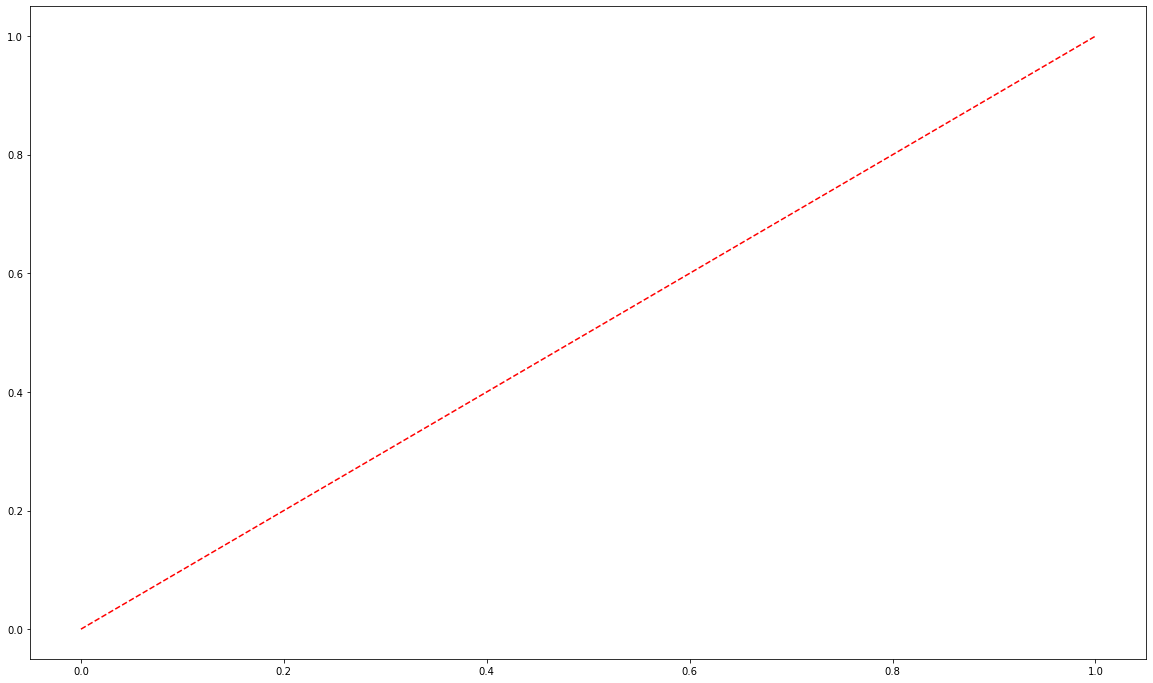

In [279]:

from sklearn.metrics import roc_curve, auc

plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'r--')

In [ ]:
#The value r-- indicates that the colour of the line is red and it is a dashed line ( — — — — — — — — — — — — — ).

In [282]:
probs = loaded_model.predict(X_test)
# Reading probability of second class (Salary >= $200K)
probs = probs[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

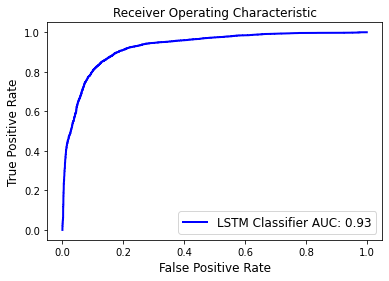

In [287]:
label = 'LSTM Classifier AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'b', label = label, linewidth = 2)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [ ]:
#The area under curve is 0.93 which is really amazing and provides the information that our model is performing great.